In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from assets.one_mask.data_generator_new import DR_Generator
from assets.one_mask.models import SMD_Unet 
from assets.one_mask.trainer_withCE import Trainer
from assets.one_mask.loss import dice_loss

#from assets.one_mask.trainer import Trainer

ma_df = pd.read_csv('../data/mask_analysis.csv')
ma_df = ma_df.fillna('x')

file_names = list(ma_df['file_name'].values)

tr_file_names = file_names[:1108]
val_file_names = file_names[1108:1660]
ts_file_names = file_names[1660:1840]

origin_tr_len = len(tr_file_names)
origin_val_len = len(val_file_names)
origin_ts_len = len(ts_file_names)

# 심각하게 넓게 잡힌 애들
useless_1 = ma_df[ma_df['넒게 잡힘'] == 'ㅇ(심각)']['file_name'].values

# 실제론 있는데 마스크가 안잡혀있는 애들
cond1 = ma_df['안잡힘'] == 'ㅇ';cond2 = ma_df['덜잡힘'] == 'ㅇ'
useless_2 = ma_df[cond1 & cond2]['file_name'].values

# 이상하게 잡힌 애들
cond1 = ma_df['넒게 잡힘'] == 'ㅇ(이상)'; cond2 = ma_df['넒게 잡힘'] == 'ㅇ(이상하게 잡힘)'
useless_3 = ma_df[cond1 | cond2]['file_name'].values

# 레이저 치료 흔적 같은 애들
cond1 = ma_df['이상함(망막박리, 레이저 등)'] == 'ㅇ'
useless_4 = ma_df[cond1]['file_name'].values

useless_files = []
useless_files.extend(useless_1)
useless_files.extend(useless_2)
useless_files.extend(useless_3)
useless_files.extend(useless_4)

tr_file_names = [file for file in tr_file_names if file not in useless_files]
val_file_names = [file for file in val_file_names if file not in useless_files]
ts_file_names = [file for file in ts_file_names if file not in useless_files]

# 쓸모없는 애들 뺴고 난 길이
print("쓸모없는 애들 뺴고 난 길이")
print("-----------------------")
print("train:", len(tr_file_names))
print("valid:",len(val_file_names))
print("test:",len(ts_file_names))

# 얼마나 빠졌는지 확인해보자
print("")
print("빠진 개수")
print("-----------------------")
print("train:", origin_tr_len - len(tr_file_names))
print("valid:", origin_val_len - len(val_file_names))
print("test:", origin_ts_len - len(ts_file_names))

# 확실히 validation이 많이 빠졌네. 값이 왜 튀었는지 이유를 알 수 있다.

쓸모없는 애들 뺴고 난 길이
-----------------------
train: 983
valid: 455
test: 152

빠진 개수
-----------------------
train: 125
valid: 97
test: 28


In [2]:
masks = ['HardExudate_Masks', 'Hemohedge_Masks', 'Microaneurysms_Masks', 'SoftExudate_Masks']
mask_dir = '../data/FGADR/Seg-set'
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]

generator_args = {
    'dir_path':'../data/FGADR/Seg-set/Original_Images/',
    'mask_path':mask_paths,
    'use_mask':True,
    'img_size':(512, 512),
    'batch_size':4, # 8로 하면 바로 OOM 뜸
    'dataset':'FGADR', # FGADR or EyePacks
    'use_3channel':True,
    'CLAHE_args':[1, (8, 8)] # [3, (8, 8)] or None
}

# tr_fgadr_gen = DR_Generator(is_train=True, file_names=tr_file_names, **generator_args)
# val_fgadr_gen = DR_Generator(is_train=False, file_names=val_file_names, **generator_args)
# ts_fgadr_gen = DR_Generator(is_train=False, file_names=ts_file_names, **generator_args)

total_file_names = []
total_file_names.extend(tr_file_names)
total_file_names.extend(val_file_names)

tr_fgadr_gen = DR_Generator(is_train=True, file_names=total_file_names, **generator_args)
ts_fgadr_gen = DR_Generator(is_train=False, file_names=ts_file_names, **generator_args)

In [3]:
model = SMD_Unet(enc_filters=[64, 128, 256, 512, 1024], dec_filters=[512, 256, 64, 32], input_channel=3)
model.load_weights("../models/one_mask/New/906_CLAHE1/55")

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 

trainer_args = {
    'model':model,
    'epochs':100,
    'optimizer':optimizer,
    'for_recons':False,   # pretraining을 할지 말지 (true = recons만 학습 한다.)
    'alpha':0.1,           # train_loss = alpha * recons_loss + mask_loss
    'beta':None,
    'first_epoch':56,
    'file_name':"history/one_mask/New/906_CLAHE1.txt",
    'save_model_path':"../models/one_mask/New/906_CLAHE1",
    'add_noise':False,
    'bce_weight':0.5 # mask_loss = dice_loss + bce_weight * bce_loss
}
trainer = Trainer(**trainer_args)

trainer.train(train_dataset=tr_fgadr_gen,
              val_dataset=ts_fgadr_gen
             )


Epoch 56/100
152/152 [==============================] - 43s 286ms/step - val_loss: 0.5157 - mask_loss: 0.5155 - loss_recons: 0.0016 - dice_loss: 0.4722 - bce_loss: 0.0865

Epoch 57/100
1404/1440 [============================>.] - ETA: 13s - train_loss: 0.4016 - mask_loss: 0.4014 - loss_recons: 0.0016 - dice_loss: 0.2905 - bce_loss: 0.0564

# 모델 결과 시각화

In [1]:
from assets.one_mask.utils import parse_history_text, parse_history_text_CE
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import os

In [2]:
os.listdir('history/one_mask/New')

['905_CLAHE1_lr0001.txt',
 '3_3channel_CE_1_CLAHE_alpha01_lr0001.txt',
 '902_CE05_lr0001.txt',
 '3_3channel_CE_1_alpha01_lr0001.txt',
 '9_CLAHE_CE.txt',
 '903_CE1_lr0001.txt',
 '2_1_alpha00_lr00001.txt',
 '.ipynb_checkpoints',
 '906_CLAHE1.txt',
 '2_alpha00_lr0001.txt',
 '902_1_CE05_lr00001.txt',
 '1_alpha01_lr0001.txt',
 '902_2_CE05_lr00001.txt',
 '8_useCLAHE.txt',
 '903_1_CE1_lr00001.txt',
 '905_1_CLAHE1_lr00001.txt',
 '1_1_alpha01_lr00001.txt',
 '9_CLAHE_CE_lr00001.txt']

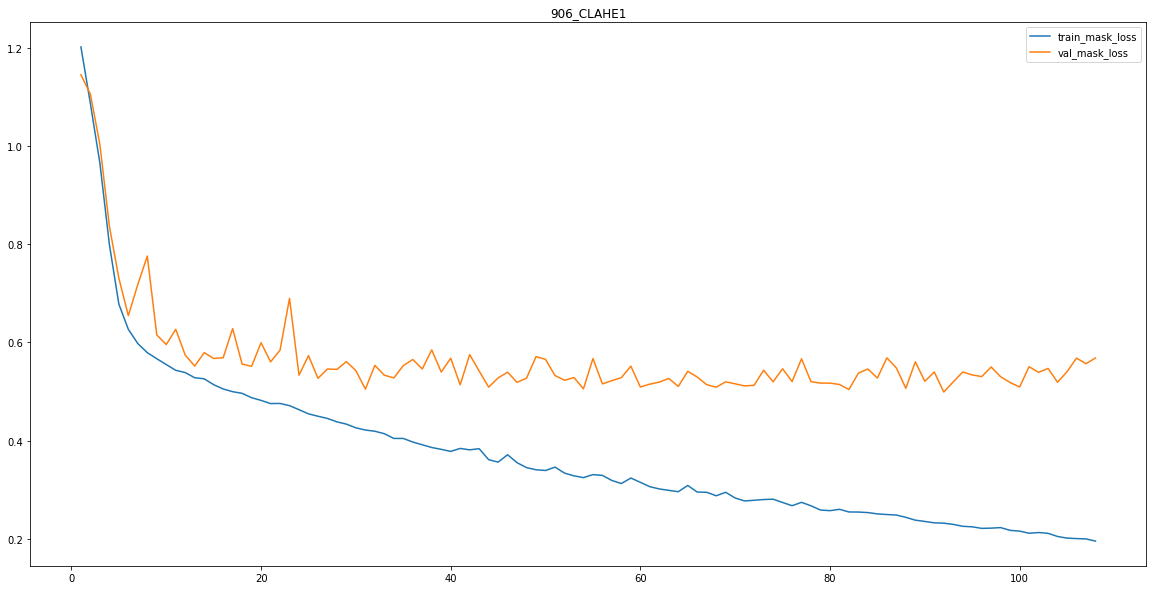

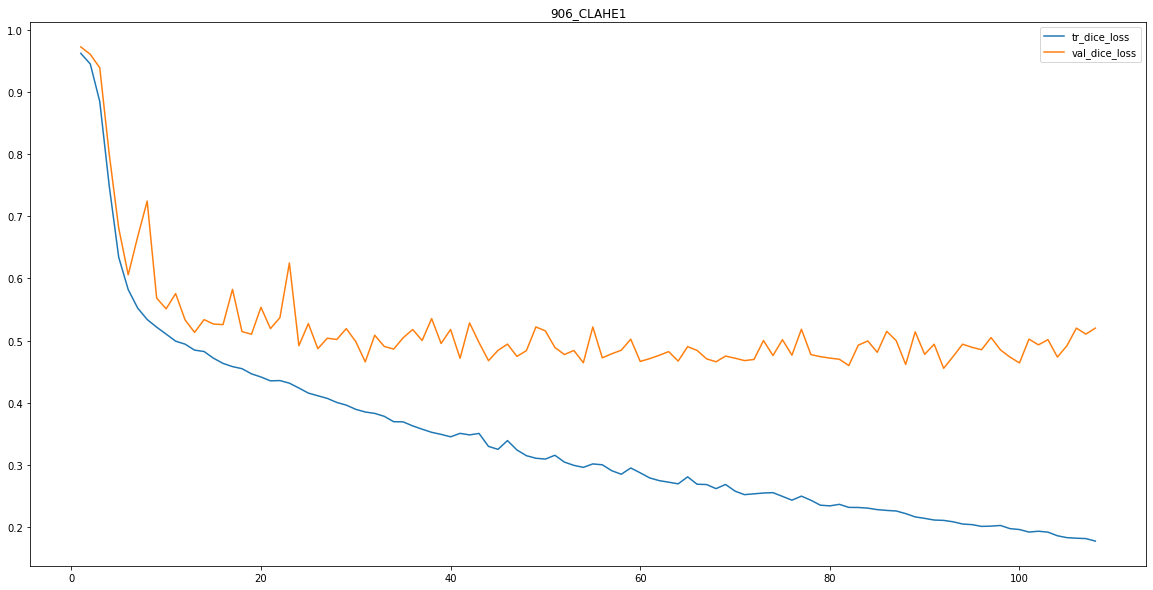

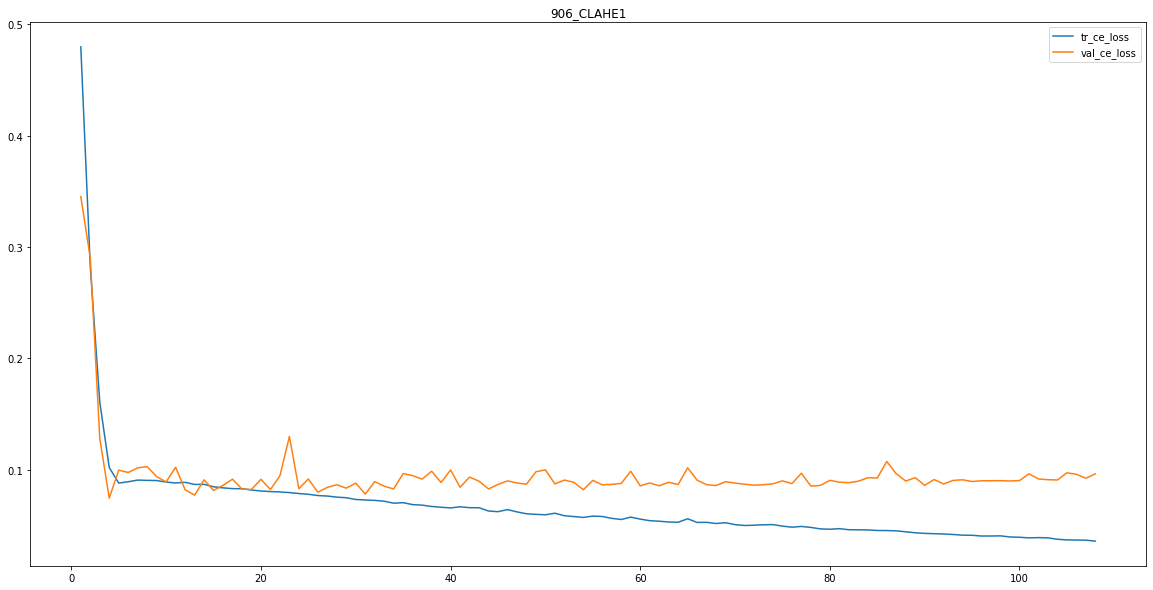

In [4]:
# history = parse_history_text('history/one_mask/New/9_CLAHE_CE_lr00001.txt')
file_name = '906_CLAHE1'
history = parse_history_text_CE(f'history/one_mask/New/{file_name}.txt')

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['train_mask_loss'], label='train_mask_loss')
plt.plot(history['epoch'], history['val_mask_loss'], label='val_mask_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['tr_dice_loss'], label='tr_dice_loss')
plt.plot(history['epoch'], history['val_dice_loss'], label='val_dice_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['tr_ce_loss'], label='tr_ce_loss')
plt.plot(history['epoch'], history['val_ce_loss'], label='val_ce_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

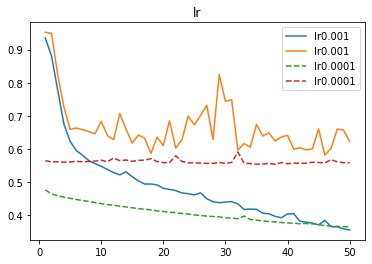

In [9]:
history = parse_history_text('history/one_mask/withoutCLAHE_withoutRecons_alpha00_lr0001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.001')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.001')


history = parse_history_text('history/one_mask/withoutCLAHE_withoutRecons_alpha00_lr00001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.0001', linestyle='--')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.0001', linestyle='--')

plt.title('lr')
plt.legend()
plt.show()

# 결과 시각화

In [ ]:
from assets.evaluation.evaluation_visual import visualize_segmentation_results

image_filenames = ["0876_2.png"]  # 원하는 이미지 파일명으로 수정
#image_filenames = result_df

mask_dir = '../data/FGADR/Seg-set'
image_dir = '../data/FGADR/Seg-set/Original_Images/'
#image_dir = '../data/FGADR/'

model_path = "../models/one_mask/New/3_3channel_CE_1_CLAHE_alpha01_lr0001/23"
visualize_segmentation_results(image_filenames, model_path, mask_dir, image_dir)